<a href="https://colab.research.google.com/github/felipe-matsuoka123/Brain_MRI_Segmentation/blob/main/Brain_MRI_image_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
from google.colab.patches import cv2_imshow
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import tensorflow as tf
import seaborn as sns
import pandas as pd

import tensorflow as tf
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout 
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate
from tensorflow.keras.losses import binary_crossentropy
from sklearn.model_selection import train_test_split
import keras.backend as K
import cv2
from tensorflow import keras

In [ ]:
masks = []
imgs = []
for id in os.listdir('/content/drive/MyDrive/KaggleCompetitionsData/MRI_segmentation/kaggle_3m'):
  for filename in os.listdir('/content/drive/MyDrive/KaggleCompetitionsData/MRI_segmentation/kaggle_3m/' + id):
    if filename[-8:] == 'mask.tif':
      masks.append('/content/drive/MyDrive/KaggleCompetitionsData/MRI_segmentation/kaggle_3m/' + id + '/' + filename)
      masks.sort()
    else:
      imgs.append('/content/drive/MyDrive/KaggleCompetitionsData/MRI_segmentation/kaggle_3m/' + id + '/' + filename)
      imgs.sort()
print('Number of masks: ' + str(len(masks)))
print('Number of images: ' +  str(len(imgs)))
      

Number of masks: 3929
Number of images: 3929


In [ ]:
masks_arrays = []

for mask in masks[0:99]:
  mk = Image.open(mask)
  mk = np.array(mk) / 255
  masks_arrays.append(mk)

images_array = []

for img in imgs[1:100]:
  im = Image.open(img)
  im = np.array(im) / 255
  images_array.append(im)

images_array = np.array(images_array)
masks_arrays = np.array(masks_arrays)

In [ ]:
positive_masks = []
positive_images = []

for i in range(99):
  if 1 in masks_arrays[i]:
    positive_masks.append(masks_arrays[i])
    positive_images.append(images_array[i])

In [ ]:
positive_masks = np.array(positive_masks)
positive_images = np.array(positive_images)
print(positive_masks.shape)
print(positive_images.shape)

(35, 256, 256)
(35, 256, 256, 3)


In [ ]:
X, y = shuffle(positive_images, positive_masks, random_state=0)

In [ ]:
 X_train, X_test,Y_train, Y_test = train_test_split(X, y, test_size=0.3)
 image_shape = X_train.shape

Define the unet's architecure 

In [ ]:
def DiceLoss(targets, inputs, smooth=1e-6):
    
    #flatten label and prediction tensors
    
    inputs = K.flatten(inputs)
    targets = K.flatten(targets)
    
    intersection = K.sum(targets *inputs)
    
    dice = (2*intersection + smooth) / (K.sum(targets) + K.sum(inputs) + smooth)
    
    return 1 - dice

In [ ]:
def EncoderMiniBlock(inputs, n_filters=32, dropout_prob=0.3, max_pooling=True):
    """
    This block uses multiple convolution layers, max pool, relu activation to create an architecture for learning. 
    Dropout can be added for regularization to prevent overfitting. 
    The block returns the activation values for next layer along with a skip connection which will be used in the decoder
    """
    # Add 2 Conv Layers with relu activation and HeNormal initialization using TensorFlow 
    # Proper initialization prevents from the problem of exploding and vanishing gradients 
    # 'Same' padding will pad the input to conv layer such that the output has the same height and width (hence, is not reduced in size) 
    conv = Conv2D(n_filters, 
                  3,   # Kernel size   
                  activation='relu',
                  padding='same',
                  kernel_initializer='HeNormal')(inputs)
    conv = Conv2D(n_filters, 
                  3,   # Kernel size
                  activation='relu',
                  padding='same',
                  kernel_initializer='HeNormal')(conv)
    
    # Batch Normalization will normalize the output of the last layer based on the batch's mean and standard deviation
    conv = BatchNormalization()(conv, training=False)

    # In case of overfitting, dropout will regularize the loss and gradient computation to shrink the influence of weights on output
    if dropout_prob > 0:     
        conv = tf.keras.layers.Dropout(dropout_prob)(conv)

    # Pooling reduces the size of the image while keeping the number of channels same
    # Pooling has been kept as optional as the last encoder layer does not use pooling (hence, makes the encoder block flexible to use)
    # Below, Max pooling considers the maximum of the input slice for output computation and uses stride of 2 to traverse across input image
    if max_pooling:
        next_layer = tf.keras.layers.MaxPooling2D(pool_size = (2,2))(conv)    
    else:
        next_layer = conv

    # skip connection (without max pooling) will be input to the decoder layer to prevent information loss during transpose convolutions      
    skip_connection = conv
    
    return next_layer, skip_connection

In [ ]:
 def DecoderMiniBlock(prev_layer_input, skip_layer_input, n_filters=32):
    """
    Decoder Block first uses transpose convolution to upscale the image to a bigger size and then,
    merges the result with skip layer results from encoder block
    Adding 2 convolutions with 'same' padding helps further increase the depth of the network for better predictions
    The function returns the decoded layer output
    """
    # Start with a transpose convolution layer to first increase the size of the image
    up = Conv2DTranspose(
                 n_filters,
                 (3,3),    # Kernel size
                 strides=(2,2),
                 padding='same')(prev_layer_input)

    # Merge the skip connection from previous block to prevent information loss
    merge = concatenate([up, skip_layer_input], axis=3)
    
    # Add 2 Conv Layers with relu activation and HeNormal initialization for further processing
    # The parameters for the function are similar to encoder
    conv = Conv2D(n_filters, 
                 3,     # Kernel size
                 activation='relu',
                 padding='same',
                 kernel_initializer='HeNormal')(merge)
    conv = Conv2D(n_filters,
                 3,   # Kernel size
                 activation='relu',
                 padding='same',
                 kernel_initializer='HeNormal')(conv)
    return conv

In [ ]:
def UNetCompiled(input_size=(256, 256, 3), n_filters=32, n_classes=5):
  inputs = Input(input_size)

  cblock1 = EncoderMiniBlock(inputs, n_filters,dropout_prob=0, max_pooling=True)

  cblock2 = EncoderMiniBlock(cblock1[0],n_filters*2,dropout_prob=0, max_pooling=True)
  cblock3 = EncoderMiniBlock(cblock2[0], n_filters*4,dropout_prob=0, max_pooling=True)
  cblock4 = EncoderMiniBlock(cblock3[0], n_filters*8,dropout_prob=0.3, max_pooling=True)
  cblock5 = EncoderMiniBlock(cblock4[0], n_filters*16, dropout_prob=0.3, max_pooling=False) 

  ublock6 = DecoderMiniBlock(cblock5[0], cblock4[1],  n_filters * 8)
  ublock7 = DecoderMiniBlock(ublock6, cblock3[1],  n_filters * 4)
  ublock8 = DecoderMiniBlock(ublock7, cblock2[1],  n_filters * 2)
  ublock9 = DecoderMiniBlock(ublock8, cblock1[1],  n_filters)
  
  conv9 = Conv2D(n_filters,
                 3,
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(ublock9)

  conv10 = Conv2D(n_classes, 1, padding='same')(conv9)
    

  model = tf.keras.Model(inputs=inputs, outputs=conv10)

  return model


In [ ]:
from tensorflow.keras import layers


def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model


# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()
img_size = (256, 256)
num_classes = 2
# Build model
model = get_model(img_size, num_classes)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 128, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                             

In [ ]:
unet = UNetCompiled(input_size=(256,256,3), n_filters = 64, n_classes=3)

unet.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy", metrics=['accuracy'])

In [ ]:
results = model.fit(X_train, Y_train,epochs=128, validation_data=(X_test, Y_test))

RuntimeError: ignored

In [ ]:
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")
epochs = 256
model.fit(X_train, Y_train,epochs=epochs, validation_data=(X_test, Y_test))

Epoch 1/256
1/1 [==============================] - 6s 6s/step - loss: 0.0060 - val_loss: 0.3182
Epoch 2/256
1/1 [==============================] - 0s 436ms/step - loss: 0.0583 - val_loss: 0.1915
Epoch 3/256
1/1 [==============================] - 0s 430ms/step - loss: 0.1256 - val_loss: 0.2334
Epoch 4/256
1/1 [==============================] - 0s 433ms/step - loss: 0.2600 - val_loss: 0.3311
Epoch 5/256
1/1 [==============================] - 0s 440ms/step - loss: 0.0861 - val_loss: 0.2569
Epoch 6/256
1/1 [==============================] - 0s 437ms/step - loss: 0.2510 - val_loss: 0.1953
Epoch 7/256
1/1 [==============================] - 0s 429ms/step - loss: 0.0439 - val_loss: 0.2119
Epoch 8/256
1/1 [==============================] - 0s 449ms/step - loss: 0.0196 - val_loss: 0.2066
Epoch 9/256
1/1 [==============================] - 0s 457ms/step - loss: 0.0131 - val_loss: 0.2078
Epoch 10/256
1/1 [==============================] - 0s 445ms/step - loss: 0.0113 - val_loss: 0.2098
Epoch 11/256

In [ ]:
val_preds = model.predict(X_train)
val_preds = val_preds



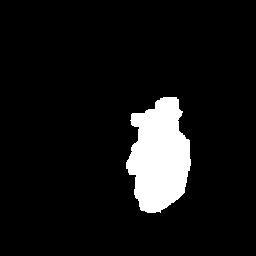

In [ ]:
from IPython.display import Image, display
from tensorflow.keras.preprocessing.image import load_img
from PIL import ImageOps

val_preds = model.predict(X_train)


def display_mask(i):
    """Quick utility to display a model's prediction."""
    mask = np.argmax(val_preds[i], axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    img = ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))
    display(img)


# Display results for validation image #10
i = 10

# Display input image


# Display ground-truth target mask



# Display mask predicted by our model
display_mask(i)  # Note that the model only sees inputs at 150x150.

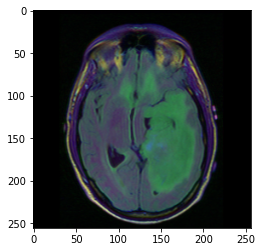

In [ ]:
plt.imshow(X_train[10])

In [ ]:
mask = np.argmax(val_preds[i], axis=-1)
mask = np.expand_dims(mask, axis=-1)
img = ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))

In [ ]:
img_array = np.array(img)

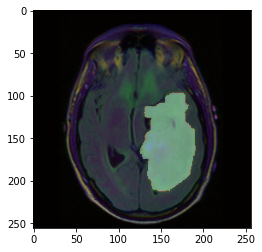

In [ ]:
plt.imshow(img_array, cmap = 'hot')
plt.imshow(X_train[10], alpha = 0.7, cmap = 'gray')

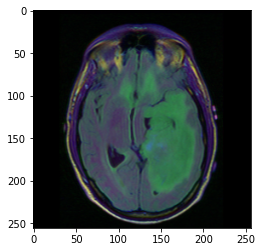

In [ ]:
plt.imshow(X_train[10])